Primeiro, vamos realizar a importação de todas as bibliotecas que usaremos.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Agora, vamos importar nossos dados.

In [66]:
df_test = pd.read_csv('../test.csv')
df = pd.read_csv('../train.csv')

In [67]:
pd.set_option('display.max_columns', None) # Configuracao para mostrar todas as colunas

## Entendendo o significado de todas as colunas

É de extrema importância entender todas as colunas, por isso, vamos copiar e colar o significado delas:

- track_id: O ID único de cada música
    
- artists: Nome dos(as) artistas que performaram a música, separados por ';'
    
- album_name: Nome do álbum no qual aparece a música
    
- track_name: Nome da música
    
- duration_ms: A duração da música em milissegundos
    
- explicit: Boolean indicando se a música possui conteúdo explícito
    
- danceability: Descreve quanto uma música é "dançante" (0.0 = menos dançante, 1.0 = mais dançante)
    
- energy: Representa a intensidade e atividade de uma música (0.0 = baixa energia, 1.0 = alta energia)
    
- key: A tonalidade musical da faixa mapeada usando a notação padrão de Classe de Altura (12 notas musicais)
    
- loudness: Nível geral de volume da faixa em decibéis (dB)
    
- mode: Indica a modalidade (maior ou menor) da faixa
    
- speechiness: Detecta a presença de palavras faladas na faixa
    
- acousticness: Medida de confiança sobre se a faixa é acústica (0,0 = não acústica, 1,0 = altamente acústica)
    
- instrumentalness: Prediz se uma faixa contém vocais (0,0 = contém vocais, 1,0 = instrumental)
    
- liveness: Detecta a presença de uma audiência na gravação (0,0 = gravação em estúdio, 1,0 = performance ao vivo)
    
- valence: Mede a positividade musical transmitida por uma faixa (0,0 = negativa, 1,0 = positiva)
    
- tempo: Tempo estimado da faixa em batidas por minuto (BPM)
    
- time_signature: Assinatura de tempo estimada da faixa (de 3 a 7)
    
- track_genre: O gênero da música
    
- popularity_target: Boolean indicando se a música é popular ou não

Realizando a análise das colunas, fiquei em dúvida sobre a diferença entre a coluna 'tempo' e 'time_signature'. Por isso, realizei uma análise mais profunda no significado delas:

* tempo (Batidas por minuto):
   * O tempo representa a velocidade ou ritmo de uma faixa, medido em batidas por minuto (BPM).
   * O tempo médio é de cerca de 122 BPM, o que representa um ritmo moderado e enérgico.
   * O tempo mínimo é 0 BPM (o que pode indicar dados ausentes ou faixas muito lentas), e o máximo é cerca de 223 BPM (muito rápido).

* time_signature (Fórmula de compasso):
   * A fórmula de compasso representa a estrutura rítmica de uma faixa, indicando quantas batidas existem em cada compasso e qual valor de nota representa uma batida.
   * Os valores geralmente variam de 3 a 7, sendo 4 o mais comum (representando o compasso 4/4, que é padrão em muitos gêneros).
   * A partir das estatísticas, podemos ver que a mediana e os percentis 25 e 75 são 4, confirmando que o compasso 4/4 é realmente o mais comum.
   * O mínimo de 0 pode indicar dados ausentes ou fórmulas de compasso não convencionais.

Primeiro dou uma olhada por cima dos dados apenas para entender quais colunas são númericas e categóricas. Também tenho a intenção de ver elas como dados reais e por isso chamo o comando `df.head(3)`

In [80]:
df.head(3)

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.849,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.320,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.190,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.133,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.509,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.544,90.459,3,idm,1


In [ ]:
df.info()

Agora partindo para uma análise mais profunda das colunas numéricas, começo com uma análise da estatística descritiva de cada coluna.

In [ ]:
df.describe()

Com o output acima, já é possível observar que valores iguais a 0 em 'tempo' e 'time_signature' provavelmente são missing values. Chegamos a essa conclusão porque músicas com 0 BPM não existem, mesmo muito lentas. E 'time_sigture' já comenta na definição das colunas que os valores vão de 3 a 7, ou seja, 0 é incorreto. Não realizamos a correção desses valores faltantes nesse exato momento, mas em breve voltaremos com eles.

## Exploração e Visualização dos Dados

Agora, na intenção de entender os dados e descobrir padrões, vamos realizar uma exploração e visualização dos dados! Para isso, vamos utilizar bibliotecas como Matplot e Seaborn. Nossa missão aqui é descobrir padrões, correlações e tendências nos dados. Vamos usar visualizações eficazes para comunicar os insights e justificar nossas futuras escolhas de features e modelos.

In [71]:
# Definindo um estilo para nossos graficos e alterando o tamanho padrão das figuras geradas pelo Matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Para o começo da nossa análise, é importante saber a quantidade de músicas que são populares ou não e saber como está a distribuição entre elas. No gráfico gerado a seguir, é possível observar que existe uma divisão bem harmoniosa entre músicas populares e não populares.

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='popularity_target', data=df)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity (0: Not Popular, 1: Popular)')
plt.ylabel('Count')
plt.show()

Partindo com nossa análise, vamos agora observar nossas variáveis numéricas e a relação entre elas. O Heatmap é um gráfico perfeito para isso que demonstra as relações entre as colunas. Resumindo bastante funciona da forma a seguir: 

Os valores de correlação variam de -1 a 1:

- **+1**: Correlação positiva perfeita. À medida que uma variável aumenta, a outra também aumenta.
- **-1**: Correlação negativa perfeita. À medida que uma variável aumenta, a outra diminui.
- **0**: Nenhuma correlação. As duas variáveis não afetam uma à outra.

In [ ]:
numerical_features = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Realizando a análise do Heatmap acima, é possível identificar alguns padrões importantes sobre nossa base de dados.

1. Correlação forte entre 'energy' e 'loudness': Existe uma correlação positiva forte (0.76) entre 'energy' e 'loudness', indicando que músicas mais enérgicas tendem a ser mais altas.

2. Correlação negativa entre 'acousticness' e 'energy': Há uma forte correlação negativa (-0.73) entre 'acousticness' e 'energy', sugerindo que músicas mais acústicas tendem a ser menos enérgicas.

3. Correlação negativa entre 'acousticness' e 'loudness': Similarmente, existe uma correlação negativa moderada (-0.59) entre 'acousticness' e 'loudness', indicando que músicas acústicas tendem a ser menos altas.

4. Correlação positiva entre 'danceability' e 'valence': Há uma correlação positiva moderada (0.48) entre 'danceability' e 'valence', sugerindo que músicas mais dançantes tendem a ter um tom emocional mais positivo.

5. Correlação negativa entre 'instrumentalness' e 'loudness': Observa-se uma correlação negativa moderada (-0.43) entre 'instrumentalness' e 'loudness', indicando que músicas mais instrumentais tendem a ser menos altas.

6. Pouca correlação com 'duration_ms': A 'duration_ms' tem correlações fracas com a maioria das outras características, sugerindo que o comprimento da música não está fortemente relacionado com suas outras propriedades acústicas.

7. Correlações fracas com 'key': A 'key' tem correlações muito fracas com outras características, indicando que não há uma relação forte entre a tonalidade e outros aspectos musicais neste conjunto de dados.

8. Correlações moderadas com 'valence': A 'valence' tem correlações moderadas positivas com 'danceability' (0.48) e 'energy' (0.26), sugerindo que músicas mais positivas tendem a ser mais dançantes e enérgicas.

9. Pouca correlação entre 'tempo' e outras características: O 'tempo' da música tem correlações relativamente fracas com outras características, com a mais forte sendo com 'energy' (0.24).

10. Correlação fraca entre 'speechiness' e outras características: 'Speechiness' tem correlações geralmente fracas com outras características, com a mais notável sendo com 'liveness' (0.21).

11. 'Liveness' tem correlações fracas: A característica 'liveness' não mostra correlações fortes com nenhuma outra característica, sugerindo que é relativamente independente das outras propriedades musicais.

Saber desses padrão será importante para quando começarmos a selecionar as features para o treinamento do nosso modelo! Porque aqui é possível observar que alguns colunas estão extremamente ligadas com outras.

Agora, queremos entender como diferentes características musicais se relacionam com a popularidade das músicas. Por isso, vamos criar alguns gráficos para realizar essa visualização.

Com essa análise, vamos identificar quais características musicais têm maior influência na popularidade de uma música.

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness']
for i, feature in enumerate(features):
    sns.boxplot(x='popularity_target', y=feature, data=df, ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title(f'{feature.capitalize()} by Popularity')
plt.tight_layout()
plt.show()

Observando o gráfico acima, conseguimos ter alguns insights.

1. Danceability (Dançabilidade):

Há uma ligeira tendência de músicas populares (1) terem maior dançabilidade.
A diferença é pequena, mas notável, o que sugere que músicas mais dançantes têm uma probabilidade um pouco maior de serem populares.

2.Instrumentalness (Instrumentalidade):

Músicas populares tendem a ter menor instrumentalidade.
Isso sugere que músicas com vocais são geralmente mais populares do que músicas puramente instrumentais.

Agora, para entender quais gêneros proporcionam mais sucessos às músicas, vamos criar um gráfico para visualizar os 10 melhores gêneros em termos de músicas populares.

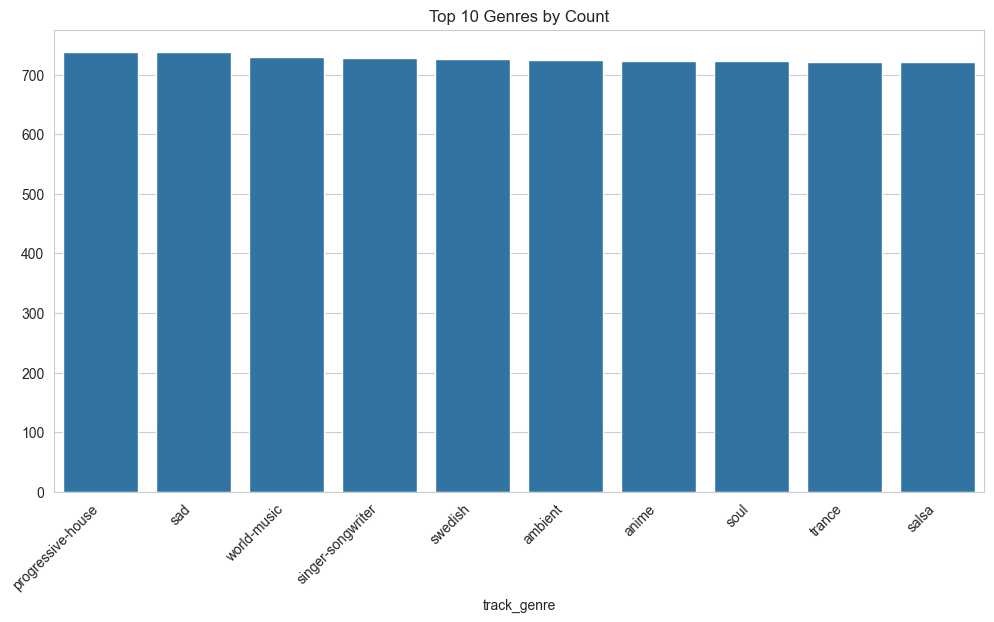

In [81]:
top_genres = df['track_genre'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='energy', y='danceability', hue='popularity_target', palette='viridis')
plt.title('Energy vs. Danceability (Colored by Popularity)')
plt.show()

Análisando o gráfico acima, podemos observar que a popularidade não parece ser exclusivamente determinada por altos níveis de energia e dançabilidade, já que músicas populares existem em diversos níveis de energia e dançabilidade, sugerindo que outros fatores também influenciam a popularidade.

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='duration_ms', bins=50, kde=True)
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (ms)')
plt.show()

Observando a duração das músicas, podemos observar que há uma concentração muito alta de músicas com duração menor. Também observamos que existem músicas com durações extremamente longas. Estes podem ser álbuns inteiros, performances ao vivo, ou erros nos dados.

- A assimetria da distribuição pode afetar análises estatísticas, sendo necessário considerar transformações ou métodos robustos. Em breve voltaremos nesse tópico ao tratar os dados.

Já o gráfico de barras empilhadas abaixo apresenta uma comparação visual da proporção de conteúdo explícito entre músicas populares e não populares 

In [ ]:
explicit_by_popularity = df.groupby('popularity_target')['explicit'].value_counts(normalize=True).unstack()
explicit_by_popularity.plot(kind='bar', stacked=True)
plt.title('Proportion of Explicit Content by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Proportion')
plt.legend(title='Explicit', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Observando o gráfico acima, podemos observar que:

1. A maioria das músicas, tanto populares quanto não populares, não contém conteúdo explícito.
2. Há uma ligeira tendência de músicas populares terem uma proporção um pouco maior de conteúdo explícito em comparação com as não populares.
3. A presença de conteúdo explícito não parece ser um fator determinante para a popularidade de uma música, dada a pequena diferença observada.

Agora para fechar nossa análise, vamos comparar a distribuição da duração das músicas entre as categorias de popularidade.

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='popularity_target', y='duration_ms', data=df)
plt.title('Song Duration Distribution by Popularity')
plt.xlabel('Popularity (0: Not Popular, 1: Popular)')
plt.ylabel('Duration (ms)')
plt.show()

Observando o gráfico acima, vemos que:

1. As medianas de duração para músicas populares e não populares são muito semelhantes, sugerindo que a duração por si só não é um forte indicador de popularidade.
2. A dispersão (representada pelo tamanho das caixas) é ligeiramente menor para músicas populares, indicando uma maior consistência na duração dessas faixas.
3. Existem muitos outliers em ambas as categorias, representando músicas com durações excepcionalmente longas.
4. As músicas populares parecem ter menos outliers extremos em comparação com as não populares, especialmente na faixa de duração mais longa.
5. A maioria das músicas, independentemente da popularidade, tem duração dentro de um intervalo relativamente estreito, como evidenciado pelo tamanho das caixas do boxplot.
6. Há uma leve tendência de músicas populares terem durações um pouco mais curtas, observável pela posição ligeiramente inferior da caixa para músicas populares.

Os insights mais importantes que encontramos em nossa análise incluem: a ligeira tendência de músicas populares terem maior energia e dançabilidade; a predominância de conteúdo não explícito em ambas as categorias de popularidade, com uma sutil inclinação para mais conteúdo explícito em músicas populares; e a observação de que a duração das músicas não é um forte indicador de popularidade, embora músicas populares tendam a ter durações mais consistentes. Além disso, notamos correlações significativas entre certas características musicais, como a relação positiva entre energia e volume (loudness), e negativa entre acústica e energia.

Ainda é muito cedo para entrarmos na escolha das features para nosso modelo, mas já é possível observar que não existe uma coluna em específica que determina a popularidade das músicas, com isso, é bastante provável que vamos utilizar todas as colunas para treinar nosso modelo, excluindo apenas as colunas de identificação.

## Formulação de Hipóteses

#### Hipótese 01: Influência da dançabilidade na era do TikTok

Com a popularização do TikTok, onde coreografias virais são frequentes, músicas mais dançantes podem ter maior probabilidade de se tornarem populares. Esta hipótese sugere uma correlação positiva entre a dançabilidade de uma música e sua popularidade.

Text(0, 0.5, 'Dançabilidade')

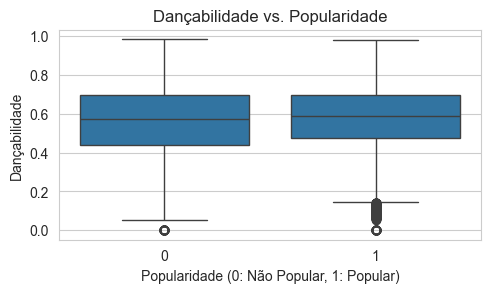

In [82]:
plt.subplot(2, 2, 1)
sns.boxplot(x='popularity_target', y='danceability', data=df)
plt.title('Dançabilidade vs. Popularidade')
plt.xlabel('Popularidade (0: Não Popular, 1: Popular)')
plt.ylabel('Dançabilidade')

É possível observar que a média de músicas dançantes é um pouco mais alto para músicas populares, mas a diferença não é tão grande assim, logo, não indica extrema importância se a música é dançante ou não para ela ser popular.

#### Hipótese 02: Conteúdo explícito em músicas de temática triste

Músicas categorizadas como "sad" ou emocionalmente intensas podem ter uma maior tendência a conter conteúdo explícito.

Text(0, 0.5, 'Proporção de Conteúdo Explícito')

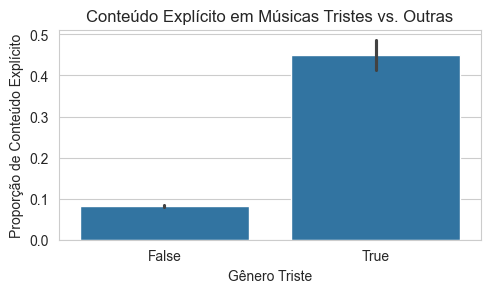

In [83]:
plt.subplot(2, 2, 2)
sad_genres = ['sad', 'melancholic', 'emotional']  # Ajuste conforme necessário
df['is_sad'] = df['track_genre'].isin(sad_genres)
sns.barplot(x='is_sad', y='explicit', data=df)
plt.title('Conteúdo Explícito em Músicas Tristes vs. Outras')
plt.xlabel('Gênero Triste')
plt.ylabel('Proporção de Conteúdo Explícito')

É possível observar que o conteúdo explícito está extremamente presente em músicas classificadas como 'sad', 'melancholic' ou 'emotional'. Comprovando nossa hipótese.

#### Hipótese 03: Popularidade de músicas com temática melancólica

Músicas classificadas como 'sad' estão entre as mais populares, principalmente porque hoje a depressão é o problema do século.

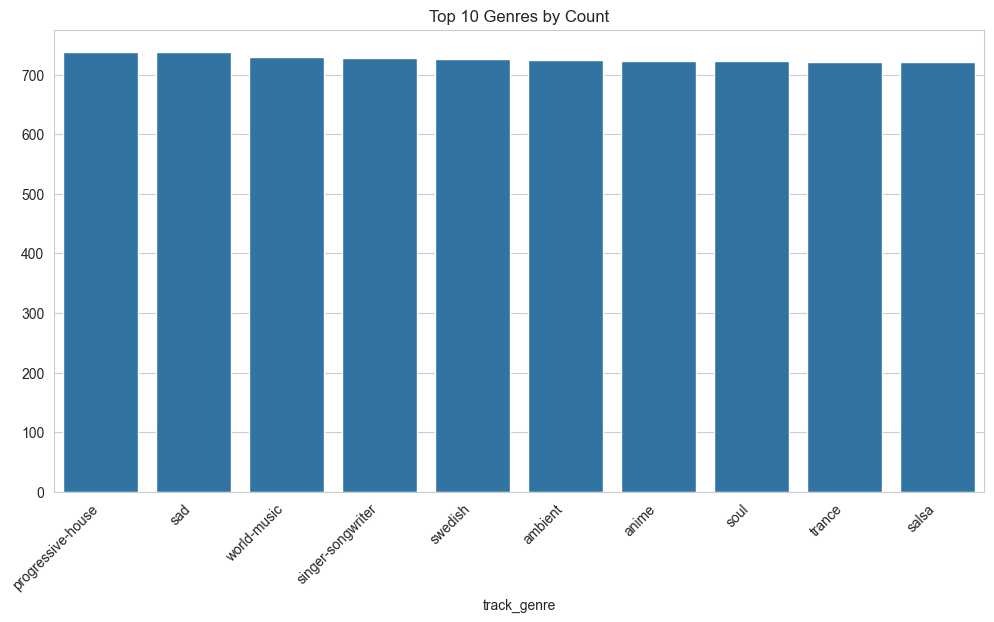

In [85]:
top_genres = df['track_genre'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

É possível ver que o gênero 'sad' é o segundo gênero com maior sucesso de músicas populares. Comprovando nossa hipótese.

#### Hipótese 04: Relação inversa entre instrumentalidade e popularidade

Músicas com alto grau de instrumentalidade (pouco ou nenhum vocal) podem tender a ser menos populares, possivelmente devido à preferência do público mainstream por músicas com letras e vozes.

Text(0, 0.5, 'Instrumentalidade')

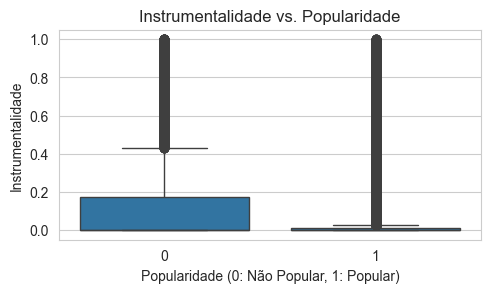

In [86]:
plt.subplot(2, 2, 4)
sns.boxplot(x='popularity_target', y='instrumentalness', data=df)
plt.title('Instrumentalidade vs. Popularidade')
plt.xlabel('Popularidade (0: Não Popular, 1: Popular)')
plt.ylabel('Instrumentalidade')

É possível observar que existem músicas populares e que são instrumentais, mas, em maioria, elas são classificadas como não populares. Comprovando nossa hipótese.